# Multi-Crop Yield Prediction: Automated Tuning & Evaluation

## Overview
This notebook automates the **LightGBM** training pipeline across **all available crops** in the dataset. 

## Methodology
1.  **Automated Discovery:** Identifies all target crops in the dataset.
2.  **Iterative Training Loop:** For each crop:
    * Isolates relevant features and target.
    * Performs Time-Series Split (Train/Val/Test).
    * Calculates Baseline (Naive) RMSE.
    * Runs **Optuna** to find the best hyperparameters.
    * Retrains the final model with best parameters.
3.  **Global Summary:** Produces a comparative DataFrame containing RMSE, R2, and improvement statistics for every crop.

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# Suppress Optuna logging to keep output clean during the loop
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

/Users/pavin/Documents/GitHub/ML_project/.venv-1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Data Loading & Crop Identification

In [2]:
# Load dataset
df = pd.read_parquet('Parquet/XY_v2.parquet')

# --- IDENTIFY CROPS ---
target_columns = [col for col in df.columns if col.startswith('Y_')]
crop_list = [col.replace('Y_', '') for col in target_columns]

print(f"Found {len(crop_list)} crops: {crop_list}")

Found 15 crops: ['bananas', 'barley', 'cassava_fresh', 'cucumbers_and_gherkins', 'maize_corn', 'oil_palm_fruit', 'other_vegetables_fresh_nec', 'potatoes', 'rice', 'soya_beans', 'sugar_beet', 'sugar_cane', 'tomatoes', 'watermelons', 'wheat']


### 2. Main Training Loop
We iterate through every crop, performing feature selection, optimization, and evaluation.

In [3]:
# Container for final results
all_results = []

# --- CONFIGURATION ---
TRAIN_END_YEAR = 2016
VAL_END_YEAR = 2020
N_TRIALS = 20  # Number of Optuna trials per crop

print("Starting Multi-Crop Optimization Loop...\n")

for crop in crop_list:
    print(f"Processing Crop: {crop.upper()}... ", end="")
    
    # 1. Define Targets
    target_col = f'Y_{crop}'
    lag_1_feature = f'avg_yield_{crop}_1y'
    
    # 2. Prepare Data Subset
    df_crop = df.dropna(subset=[target_col]).copy()
    
    # 3. Feature Selection (Drop other crop yields)
    cols_to_drop = [c for c in df_crop.columns 
                    if c.startswith("avg_yield_") and crop not in c]
    df_crop = df_crop.drop(columns=cols_to_drop)
    
    feature_cols = [c for c in df_crop.columns 
                    if not c.startswith('Y_') and c not in ['year', 'area']]
    
    # 4. Time-Series Split
    # Train
    mask_train = df_crop['year'] < TRAIN_END_YEAR
    X_train = df_crop[mask_train][feature_cols]
    y_train = df_crop[mask_train][target_col]

    # Validation
    mask_val = (df_crop['year'] >= TRAIN_END_YEAR) & (df_crop['year'] < VAL_END_YEAR)
    X_val = df_crop[mask_val][feature_cols]
    y_val = df_crop[mask_val][target_col]

    # Test
    mask_test = df_crop['year'] >= VAL_END_YEAR
    X_test = df_crop[mask_test][feature_cols]
    y_test = df_crop[mask_test][target_col]
    
    # 5. Calculate Baseline (Last Year's Yield)
    y_pred_baseline = X_test[lag_1_feature]
    # Handle NaNs in lag for metric calc
    mask_valid = ~y_pred_baseline.isna() & ~y_test.isna()
    rmse_baseline = np.sqrt(mean_squared_error(y_test[mask_valid], y_pred_baseline[mask_valid]))
    
    # 6. Define Optuna Objective (Internal function to capture local variables)
    def objective(trial):
        params = {
            'n_estimators': 1000,
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.15),
            'num_leaves': trial.suggest_int('num_leaves', 20, 150),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            'random_state': 42,
            'n_jobs': -1,
            'verbose': -1
        }
        
        model = lgb.LGBMRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='rmse',
            callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=False)]
        )
        
        preds = model.predict(X_val)
        return np.sqrt(mean_squared_error(y_val, preds))

    # 7. Run Optimization
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=N_TRIALS)
    
    # 8. Train Final Model (Train + Val data used for final fit recommended, but using Train history here for consistency)
    # For best results, we often concatenate Train+Val, but let's stick to the optimized params on Train
    best_params = study.best_params
    best_params['n_estimators'] = 1000
    best_params['n_jobs'] = -1
    best_params['random_state'] = 42
    best_params['verbose'] = -1
    
    final_model = lgb.LGBMRegressor(**best_params)
    final_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )
    
    # 9. Final Evaluation
    y_pred = final_model.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
    r2_test = r2_score(y_test, y_pred)
    
    # 10. Store Results
    result_entry = {
        'Crop': crop.capitalize(),
        'Baseline RMSE': round(rmse_baseline, 2),
        'Tuned RMSE': round(rmse_test, 2),
        'Improvement (%)': round((rmse_baseline - rmse_test) / rmse_baseline * 100, 2),
        'R2 Score': round(r2_test, 4),
        'Best Params': str(best_params) # Stored as string to fit in DF cleanly
    }
    all_results.append(result_entry)
    
    print(f"Done. (RMSE: {rmse_test:.2f} | R2: {r2_test:.4f})")

print("\nOptimization Loop Complete.")

Starting Multi-Crop Optimization Loop...

Processing Crop: BANANAS... Done. (RMSE: 4764.93 | R2: 0.9257)
Processing Crop: BARLEY... Done. (RMSE: 846.33 | R2: 0.8218)
Processing Crop: CASSAVA_FRESH... Done. (RMSE: 2370.91 | R2: 0.9168)
Processing Crop: CUCUMBERS_AND_GHERKINS... Done. (RMSE: 26238.04 | R2: 0.9200)
Processing Crop: MAIZE_CORN... Done. (RMSE: 1877.55 | R2: 0.8081)
Processing Crop: OIL_PALM_FRUIT... Done. (RMSE: 794.74 | R2: 0.9615)
Processing Crop: OTHER_VEGETABLES_FRESH_NEC... Done. (RMSE: 2422.46 | R2: 0.9472)
Processing Crop: POTATOES... Done. (RMSE: 2431.22 | R2: 0.9493)
Processing Crop: RICE... Done. (RMSE: 488.03 | R2: 0.9524)
Processing Crop: SOYA_BEANS... Done. (RMSE: 356.04 | R2: 0.8250)
Processing Crop: SUGAR_BEET... Done. (RMSE: 6605.51 | R2: 0.9267)
Processing Crop: SUGAR_CANE... Done. (RMSE: 5634.01 | R2: 0.9537)
Processing Crop: TOMATOES... Done. (RMSE: 8996.03 | R2: 0.9864)
Processing Crop: WATERMELONS... Done. (RMSE: 31266.44 | R2: 0.2418)
Processing Crop: 

### 3. Final Summary Report

,Crop,Baseline RMSE,Tuned RMSE,Improvement (%),R2 Score,Best Params
12,Tomatoes,8962.18,8996.03,-0.38,0.9864,"{'learning_rate': 0.006755682134973007, 'num_l..."
5,Oil_palm_fruit,720.34,794.74,-10.33,0.9615,"{'learning_rate': 0.058100937660681924, 'num_l..."
11,Sugar_cane,5815.01,5634.01,3.11,0.9537,"{'learning_rate': 0.08460647335419039, 'num_le..."
8,Rice,525.00,488.03,7.04,0.9524,"{'learning_rate': 0.14473942680430102, 'num_le..."
7,Potatoes,2488.01,2431.22,2.28,0.9493,"{'learning_rate': 0.0371042834366247, 'num_lea..."
6,Other_vegetables_fresh_nec,2357.12,2422.46,-2.77,0.9472,"{'learning_rate': 0.060955717818796384, 'num_l..."
14,Wheat,612.57,533.70,12.88,0.9326,"{'learning_rate': 0.007085528847190882, 'num_l..."
10,Sugar_beet,6525.05,6605.51,-1.23,0.9267,"{'learning_rate': 0.08083359559696601, 'num_le..."
0,Bananas,4367.19,4764.93,-9.11,0.9257,"{'learning_rate': 0.06990307781877005, 'num_le..."
3,Cucumbers_and_gherkins,25782.03,26238.04,-1.77,0.9200,"{'learning_rate': 0.012163130067206013, 'num_l..."


/var/folders/zn/lrmslqwn0g3_slr732tvb0zw0000gn/T/ipykernel_14768/3335969598.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x='Crop', y='R2 Score', palette='viridis')


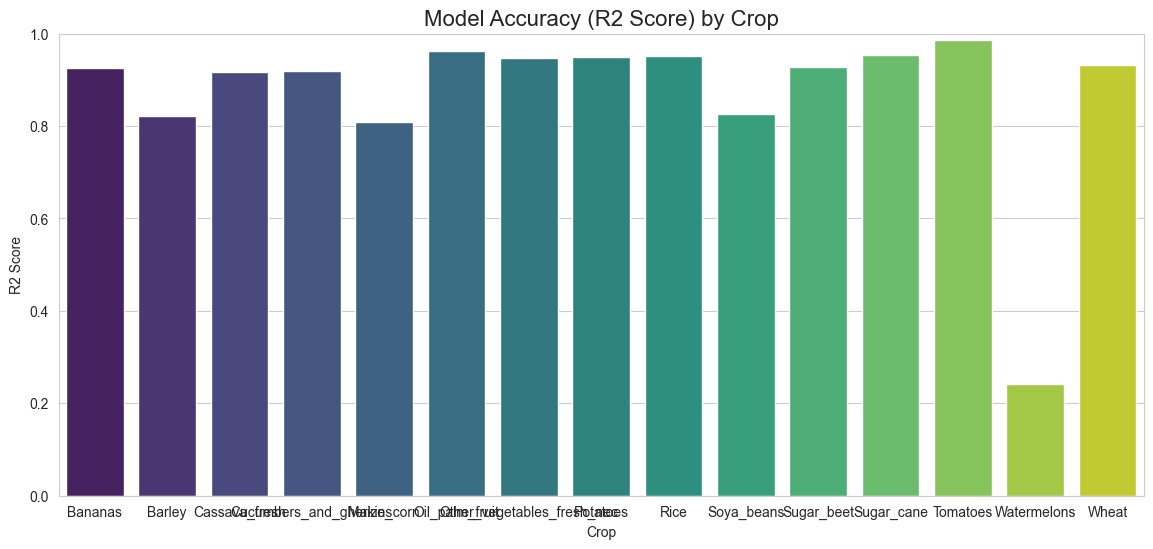

In [4]:
# Create DataFrame
summary_df = pd.DataFrame(all_results)

# Reorder columns for readability
cols = ['Crop', 'Baseline RMSE', 'Tuned RMSE', 'Improvement (%)', 'R2 Score', 'Best Params']
summary_df = summary_df[cols]

# Display sorted by best R2 score
display(summary_df.sort_values(by='R2 Score', ascending=False))

# Visualize R2 Scores across crops
plt.figure(figsize=(14, 6))
sns.barplot(data=summary_df, x='Crop', y='R2 Score', palette='viridis')
plt.title('Model Accuracy (R2 Score) by Crop', fontsize=16)
plt.ylim(0, 1.0)
plt.show()